In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from src.vimlts import VIMLTS
from matplotlib import pyplot as plt
from tensorflow_probability import distributions as tfd
import numpy as np
import seaborn as sns
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations, initializers
from tensorflow.keras import backend as K
from src import vimlts_utils_keras as VIMLTS_utils
# from src.vimlts_keras import DenseVIMLTS

%load_ext autoreload
%autoreload 2
sns.set(style="darkgrid")

## Load single weight experiment

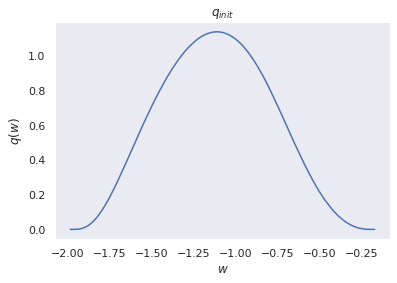

In [2]:
# Variational parameters init
a_init=(0.2,)
b_init=(0.3,)
alpha_init = (np.log(np.exp(0.2) -1),)
beta_init = (1.,)
# List to save the variational distribution during training
q_history=[]

tf.random.set_seed(1)
np.random.seed(1)
delta_theta_init = (-5,1.,0.8,0.8,0.6,0.4,0.2,0.2,1.,.0)
lambda_init=a_init+b_init+delta_theta_init+alpha_init+beta_init
num_lambda=np.shape(lambda_init)[0]
lambda_tunable = tf.Variable(lambda_init,dtype='float32')
# Instance of a variational distribution as VIMLTS
q_dist=VIMLTS(np.shape(delta_theta_init)[0])
# Update the variational parameter to the variational distribution
q_dist.update_lambda_param(lambda_tunable)
# Save the distribution to the history
q_history.append(q_dist.get_target_dist())
for hist in q_history:
    plt.plot(hist[1],hist[0])
# plt.legend()
plt.grid()
plt.title(r'$q_{init}$')
plt.ylabel(r'$q(w)$')
plt.xlabel(r'$w$');

In [3]:
w_single = []
test_z = np.linspace(-2,2,5, dtype=np.float32)

# tf.config.run_functions_eagerly(True)
for z_ in test_z:
    z_ = tf.Variable(z_, trainable=True)
    q_dist=VIMLTS(np.shape(delta_theta_init)[0])
    # Update the variational parameter to the variational distribution
    q_dist.update_lambda_param(lambda_tunable)
    q_dist, w = q_dist.get_target_dist_for_z(z_)
    w_single.append(w)
    print(w)

tf.Tensor([-1.7052318], shape=(1,), dtype=float32)
tf.Tensor([-1.4543245], shape=(1,), dtype=float32)
tf.Tensor([-1.11914], shape=(1,), dtype=float32)
tf.Tensor([-0.78463733], shape=(1,), dtype=float32)
tf.Tensor([-0.51165223], shape=(1,), dtype=float32)


## Compare with keras implementation

In [4]:
kernel_a = VIMLTS_utils.to_a(tf.reshape(a_init, (1,1,1)))
kernel_theta = VIMLTS_utils.to_theta(delta_theta_init)
kernel_theta = VIMLTS_utils.to_theta(tf.reshape(delta_theta_init, (-1,1,1)))
kernel_theta=tf.transpose(kernel_theta, perm=[1, 2, 0])
kernel_alpha = VIMLTS_utils.to_alpha(tf.reshape(alpha_init, (1,1,1)))
kernel_alpha = tf.cast(kernel_alpha, dtype=tf.float32)
kernel_z_sample = tf.cast(np.linspace(-2,2,5), dtype=tf.float32)
kernel_beta_dist = VIMLTS_utils.init_beta_dist(len(delta_theta_init))

In [5]:
w_keras = []
# tf.config.run_functions_eagerly(True)
for z in kernel_z_sample:
    kernel_w_sample=VIMLTS_utils.kernel_h_z2w(z=z[None, None],
                                              a=kernel_a,
                                              b=b_init,
                                              theta=kernel_theta,
                                              alpha=kernel_alpha,
                                              beta=beta_init,
                                              beta_dist=kernel_beta_dist)
    print(kernel_w_sample)
    w_keras.append(kernel_w_sample)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf.Tensor([[[-1.7052319]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[-1.4543245]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[-1.11914]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[-0.7846373]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[-0.5116521]]], shape=(1, 1, 1), dtype=float32)


In [6]:
class VimltsLinear(tf.keras.layers.Layer):
    def __init__(self, units, alpha_w=1., beta_w=0., alpha_z=1., beta_z=0., theta=[1.], num_samples=10):
        super().__init__()
        self.alpha_w_init = alpha_w
        self.beta_w_init = beta_w
        self.alpha_z_init = alpha_z
        self.beta_z_init = beta_z
        self.theta_init = theta
        self.units_ = units
        self.num_samples_ = num_samples
        self.prior_dist_ = tfd.Normal(loc=0., scale=1.)
        self.beta_dist = self.init_beta_dist(len(theta))
        self.z_dist_ = None

    @staticmethod
    def init_beta_dist(M):
        in1 = []
        in2 = []
        for i in range(1,M+1):
            in1.append(i)
            in2.append(M-i+1)
        # print("Koeffizienten beta_dist:")
        # print(f'in1 = {in1}')
        # print(f'in2 = {in2}')
        return tfd.Beta(in1,in2)

    def build(self, input_shape):
        """
        Initialization of the trainable variational parameters, for x (independent of #units) and for bias
        """

        # Kernel
        self.z_dist_ = tfd.Normal(loc=tf.zeros((input_shape[1], self.units_)), scale=tf.ones((input_shape[1], self.units_)))
        self.alpha_w = self.add_weight(shape=(input_shape[1], self.units_),
                                       initializer=tf.constant_initializer(self.alpha_w_init),
                                       trainable=True)
        self.beta_w = self.add_weight(shape=(input_shape[1], self.units_),
                                       initializer=tf.constant_initializer(self.beta_w_init),
                                       trainable=True)
        self.alpha_z = self.add_weight(shape=(input_shape[1], self.units_),
                                       initializer=tf.constant_initializer(self.alpha_z_init),
                                       trainable=True)
        self.beta_z = self.add_weight(shape=(input_shape[1], self.units_),
                                       initializer=tf.constant_initializer(self.beta_z_init),
                                       trainable=True)
        theta_prime = tf.tile(self.theta_init, [input_shape[1] * self.units_])
        theta_prime = tf.reshape(theta_prime, (input_shape[1], self.units_, len(self.theta_init)))
        self.theta_prime = tf.Variable(initial_value=theta_prime, trainable=True)
        super().build(input_shape)

    def f_1(self, z):
        """

        :param z: [#samples x #input x #output]
        :return: [#samples x #input x #output]
        """
        z_ = tf.math.multiply(tf.math.softplus(self.alpha_z), z) - self.beta_z
        return  tf.math.sigmoid(z_)

    def f_2(self, z_):
        """

        :param z_: [#samples x #input x #output]
        :return:
        """
        theta_p = self.theta_prime  # [#input x #output x M]
        theta_p = tf.concat((theta_p[...,0:1], tf.math.softplus(theta_p[...,1:])), axis=-1)

        n=theta_p.shape[-1]
        tf.ones((n*(n+1) // 2))
        m_triangle = tfp.math.fill_triangular(tf.ones(n*(n+1) // 2), upper=True)

        theta = theta_p @ m_triangle
        fIm=self.beta_dist.prob(z_[...,None]) # to broadcast beta dist [#samples x #input x #output x M]
        return tf.math.reduce_mean(fIm * theta, axis=-1)
        # return z_

    def f_3(self, z_w):
        """

        :type z_w: object
        :return: shape [#sample x #input x #output]
        """
        return tf.math.multiply(tf.math.softplus(self.alpha_w), z_w) - self.beta_w

    def get_w_dist(self, num=1000):
        with tf.GradientTape() as tape:
            zz=tf.dtypes.cast(tf.reshape(tf.linspace(-6,6,num), shape=(-1,1,1)), tf.float32)
            tape.watch(zz)
            w = self.f_3(self.f_2(self.f_1(zz)))
            dw_dz = tape.gradient(w, zz)
        # tf.reduce_prod(w.shape[1:]) -> undo gradiant adding because of zz broadcasting
        dw_dz /= tf.cast(tf.reduce_prod(w.shape[1:]), dtype=tf.float32)
        p_z = self.z_dist_.log_prob(zz)
        q_w = p_z - tf.math.log(tf.math.abs(dw_dz))
        return q_w,w

    def call(self, inputs, **kwargs):
        """

        :param inputs: [#batch x #input]
        :param kwargs:
        :return: [#samples x #batch x #output]
        """
        with tf.GradientTape() as tape:
            z = self.z_dist_.sample(self.num_samples_)
            print(z)
            tape.watch(z)
            w = self.f_3(self.f_2(self.f_1(z)))
            dw_dz = tape.gradient(w, z)
        # compute kl divergence
        log_p_w = self.prior_dist_.log_prob(w)
        # change of variable ==> p(w) = p(z)/|dw/dz|
        log_p_z = self.z_dist_.log_prob(z)
        # print("dw_dz: ", dw_dz)
        # log rules ==> log(p(w)) = log(p(z)) - log(|dw/dz|)
        log_q_w = log_p_z - tf.math.log(tf.math.abs(dw_dz))
        kl =  tf.reduce_sum(tf.reduce_mean(log_q_w,0)) - tf.reduce_sum(tf.reduce_mean(log_p_w,0))
        self.add_loss(kl)

        return inputs @ w
        # return w

vimlts_f = VimltsLinear(2, alpha_z=a_init[0], beta_z=b_init[0], alpha_w=alpha_init[0], beta_w=beta_init[0], theta=delta_theta_init)
vimlts_f.build(input_shape=(None, 1))
z_ = vimlts_f.f_1(tf.reshape(test_z, (-1,1,1)))
z_ = vimlts_f.f_2(z_)
w_fast = vimlts_f.f_3(z_)
w_fast = w_fast.numpy().squeeze()

Area under pdf:  0.99999565


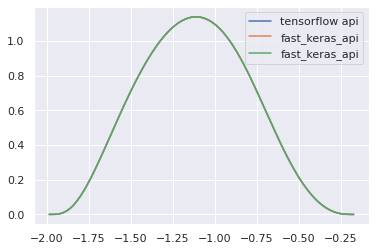

In [7]:
plt.plot(q_history[0][1],q_history[0][0], label="tensorflow api")
q, w = vimlts_f.get_w_dist(1000)
q = np.exp(q)

plt.plot(w.numpy()[:,0,:],q[:,0,:], label="fast_keras_api")
plt.legend()
print("Area under pdf: ",np.trapz(q[:,0,0],w[:,0,0]))

### Compare if the three implementations.
They must have the same h_z_to_w transformation if we use the same \lambda parameters.

In [8]:
from pandas import DataFrame as df
df.from_dict(dict(z_sample=test_z,
                  w_basic=np.array(w_single).squeeze(),
                  w_keras=np.array(w_keras).squeeze(),
                  w_keras_fast_first_neuron=w_fast[:,0],
                  w_keras_fast_second_neuron=w_fast[:,1],
                  ))

,z_sample,w_basic,w_keras,w_keras_fast_first_neuron,w_keras_fast_second_neuron
0,-2.0,-1.705232,-1.705232,-1.705232,-1.705232
1,-1.0,-1.454324,-1.454324,-1.454324,-1.454324
2,0.0,-1.119140,-1.119140,-1.119140,-1.119140
3,1.0,-0.784637,-0.784637,-0.784637,-0.784637
4,2.0,-0.511652,-0.511652,-0.511652,-0.511652


# Comparer KL div

In [9]:
class DenseVIMLTS(Layer):


    def __init__(self,
                 units,
                 kl_weight,
                 init_tilde_a,
                 init_b,
                 init_tilde_alpha,
                 init_beta,
                 init_theta,
                 num_samples_per_epoch=2,
                 activation=None,
                 prior_mu=0.,
                 prior_sigma=1.,
                 kernel_m=10,
                 bias_m=10, **kwargs):
        self.init_tilde_a = init_tilde_a
        self.init_b = init_b
        self.init_tilde_alpha = init_tilde_alpha
        self.init_beta = init_beta
        self.init_theta = init_theta
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.kernel_m=kernel_m
        self.bias_m=bias_m
        self.kernel_beta_dist=VIMLTS_utils.init_beta_dist(self.kernel_m)
        self.bias_beta_dist=VIMLTS_utils.init_beta_dist(self.bias_m)
        self.epsilon=tf.constant(0.001)
        self.init_gauss=True
        self.num_samples=num_samples_per_epoch

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units


    def build(self, input_shape):
        """
        Initialization of the trainable variational parameters, for x (independent of #units) and for bias
        """

        # Kernel
        self.kernel_tilde_a = self.add_weight(name='kernel_tilde_a',
                                          shape=(input_shape[1], self.units),
                                             initializer=initializers.Constant(self.init_tilde_a),
                                          trainable=True)
        self.kernel_b = self.add_weight(name='kernel_b',
                                          shape=(input_shape[1], self.units),
                                     initializer=initializers.Constant(self.init_b),
                                          trainable=True)

        self.kernel_start_theta = self.add_weight(name='kernel_start_theta',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[0]),
                                          trainable=True)
        self.kernel_delta_theta_1 = self.add_weight(name='kernel_delta_theta_1',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[1]),
                                          trainable=True)
        self.kernel_delta_theta_2 = self.add_weight(name='kernel_delta_theta_2',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[2]),
                                          trainable=True)
        self.kernel_delta_theta_3 = self.add_weight(name='kernel_delta_theta_3',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[3]),
                                          trainable=True)
        self.kernel_delta_theta_4 = self.add_weight(name='kernel_delta_theta_4',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[4]),
                                          trainable=True)
        self.kernel_delta_theta_5 = self.add_weight(name='kernel_delta_theta_5',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[5]),
                                          trainable=True)
        self.kernel_delta_theta_6 = self.add_weight(name='kernel_delta_theta_6',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[6]),
                                          trainable=True)
        self.kernel_delta_theta_7 = self.add_weight(name='kernel_delta_theta_7',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[7]),
                                          trainable=True)
        self.kernel_delta_theta_8 = self.add_weight(name='kernel_delta_theta_8',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[8]),
                                          trainable=True)
        self.kernel_delta_theta_9 = self.add_weight(name='kernel_delta_theta_9',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_theta[9]),
                                          trainable=True)

        self.kernel_tilde_alpha = self.add_weight(name='kernel_tilde_alpha',
                                          shape=(input_shape[1], self.units),
                                                 initializer=initializers.Constant(self.init_tilde_alpha),
                                          trainable=True)
        self.kernel_beta = self.add_weight(name='kernel_beta',
                                          shape=(input_shape[1], self.units),
                                         initializer=initializers.Constant(self.init_beta),
                                          trainable=True)


        # Bias
        self.bias_tilde_a = self.add_weight(name='bias_tilde_a',
                                          shape=(self.units,),
                                         initializer=initializers.Constant(self.init_tilde_a),
                                          trainable=True)
        self.bias_b = self.add_weight(name='bias_b',
                                          shape=(self.units,),
                                     initializer=initializers.Constant(self.init_b),
                                          trainable=True)

        self.bias_start_theta = self.add_weight(name='bias_start_theta',
                                          shape=(self.units,),
                                             initializer=initializers.Constant(self.init_theta[0]),
                                          trainable=True)
        self.bias_delta_theta_1 = self.add_weight(name='bias_delta_theta_1',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[1]),
                                          trainable=True)
        self.bias_delta_theta_2 = self.add_weight(name='bias_delta_theta_2',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[2]),
                                          trainable=True)
        self.bias_delta_theta_3 = self.add_weight(name='bias_delta_theta_3',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[3]),
                                          trainable=True)
        self.bias_delta_theta_4 = self.add_weight(name='bias_delta_theta_4',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[4]),
                                          trainable=True)
        self.bias_delta_theta_5 = self.add_weight(name='bias_delta_theta_5',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[5]),
                                          trainable=True)
        self.bias_delta_theta_6 = self.add_weight(name='bias_delta_theta_6',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[6]),
                                          trainable=True)
        self.bias_delta_theta_7 = self.add_weight(name='bias_delta_theta_7',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[7]),
                                          trainable=True)
        self.bias_delta_theta_8 = self.add_weight(name='bias_delta_theta_8',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[8]),
                                          trainable=True)
        self.bias_delta_theta_9 = self.add_weight(name='bias_delta_theta_9',
                                          shape=(self.units,),
                                                 initializer=initializers.Constant(self.init_theta[9]),
                                          trainable=True)

        self.bias_tilde_alpha = self.add_weight(name='bias_tilde_alpha',
                                          shape=(self.units,),
                                             initializer=initializers.Constant(self.init_tilde_alpha),
                                          trainable=True)
        self.bias_beta = self.add_weight(name='bias_beta',
                                          shape=(self.units,),
                                         initializer=initializers.Constant(self.init_beta),
                                          trainable=True)
        super().build(input_shape)


    def call(self, inputs, **kwargs):
        """Calculation of the forward direction of the network by
        -drawing parameters
        -Calculation loss KL
        -Calculation output of the layer
        """

        # 1.) Conversion of trainable variational parameters to parameters of distribution (x)
        kernel_a = VIMLTS_utils.to_a(self.kernel_tilde_a)
        kernel_theta = VIMLTS_utils.to_theta([self.kernel_start_theta,
                                        self.kernel_delta_theta_1,
                                        self.kernel_delta_theta_2,
                                        self.kernel_delta_theta_3,
                                        self.kernel_delta_theta_4,
                                        self.kernel_delta_theta_5,
                                        self.kernel_delta_theta_6,
                                        self.kernel_delta_theta_7,
                                        self.kernel_delta_theta_8,
                                        self.kernel_delta_theta_9])
        kernel_theta=tf.transpose(kernel_theta, perm=[1, 2, 0])
        kernel_alpha = VIMLTS_utils.to_alpha(self.kernel_tilde_alpha)

        # 3.) Conversion of trainable variational parameters to parameters of distribution (bias)
        bias_a = VIMLTS_utils.to_a(self.bias_tilde_a)
        bias_theta = VIMLTS_utils.to_theta([self.bias_start_theta,
                                        self.bias_delta_theta_1,
                                        self.bias_delta_theta_2,
                                        self.bias_delta_theta_3,
                                        self.bias_delta_theta_4,
                                        self.bias_delta_theta_5,
                                        self.bias_delta_theta_6,
                                        self.bias_delta_theta_7,
                                        self.bias_delta_theta_8,
                                        self.bias_delta_theta_9])
        bias_theta=tf.transpose(bias_theta, perm=[1, 0])
        bias_alpha = VIMLTS_utils.to_alpha(self.bias_tilde_alpha)


        # 2.) Sampling from variational dist by reparametrization trick - prototype version (x)
        samples = tf.random.normal((self.num_samples,)+self.kernel_tilde_a.shape)
        for current_sample, kernel_z_sample in enumerate(samples):
            # kernel_z_sample=tf.random.normal(self.kernel_tilde_a.shape)
            print("keras z sample: ", kernel_z_sample)
            kernel_w_sample=VIMLTS_utils.kernel_h_z2w(z=kernel_z_sample,
                                            a=kernel_a,
                                            b=self.kernel_b,
                                            theta=kernel_theta,
                                            alpha=kernel_alpha,
                                            beta=self.kernel_beta,
                                            beta_dist=self.kernel_beta_dist)

            if current_sample==0:
                kernel_w_sample_list=tf.reshape(kernel_w_sample,[1,kernel_w_sample.shape[0],kernel_w_sample.shape[1]])
            else:
                kernel_w_sample_list=tf.concat([kernel_w_sample_list,tf.reshape(kernel_w_sample,[1,kernel_w_sample.shape[0],kernel_w_sample.shape[1]])],axis=0)

            print("keras w sample: ", kernel_w_sample)

            # 4.) Sampling from variational dist by reparametrization trick - prototype version (bias)
            bias_z_sample=tf.random.normal(self.bias_tilde_a.shape)
            bias_w_sample=VIMLTS_utils.bias_h_z2w(z=bias_z_sample,
                                            a=bias_a,
                                            b=self.bias_b,
                                            theta=bias_theta,
                                            alpha=bias_alpha,
                                            beta=self.bias_beta,
                                            beta_dist=self.bias_beta_dist)
            if current_sample==0:
                bias_w_sample_list=tf.reshape(bias_w_sample,[1,bias_w_sample.shape[0]])
            else:
                bias_w_sample_list=tf.concat([bias_w_sample_list,tf.reshape(bias_w_sample,[1,bias_w_sample.shape[0]])],axis=0)


            # 5.) Calculation l_kl by calling function with passing the sample and the variational parameters (x and bias)

            kernel_kl_loss=self.calc_kernel_kl_loss(kernel_w_sample=kernel_w_sample,
                                kernel_z_sample=kernel_z_sample,
                                kernel_a=kernel_a,
                                kernel_theta=kernel_theta,
                                kernel_alpha=kernel_alpha)
            if current_sample==0:
                kernel_kl_loss_sum=kernel_kl_loss
            else:
                kernel_kl_loss_sum+=kernel_kl_loss


            bias_kl_loss=self.calc_bias_kl_loss(bias_w_sample=bias_w_sample,
                                bias_z_sample=bias_z_sample,
                                bias_a=bias_a,
                                bias_theta=bias_theta,
                                bias_alpha=bias_alpha)
            if current_sample==0:
                bias_kl_loss_sum=bias_kl_loss
            else:
                bias_kl_loss_sum+=bias_kl_loss


        # self.add_loss(1/self.num_samples*kernel_kl_loss_sum+1/self.num_samples*bias_kl_loss_sum)
        self.add_loss(1/self.num_samples*kernel_kl_loss_sum)

        kernel_mean=tf.reduce_mean(kernel_w_sample_list,axis=0)
        bias_mean=tf.reduce_mean(bias_w_sample_list,axis=0)

        # 6.) Calculation output of the layer
        # return self.activation(K.dot(inputs, kernel_mean)+ bias_mean)
        return K.dot(inputs, kernel_mean)

    def calc_kernel_kl_loss(self,kernel_w_sample,kernel_z_sample,kernel_a,kernel_theta,kernel_alpha):
        kernel_z_epsilon=kernel_z_sample+self.epsilon
        kernel_q,w_check=VIMLTS_utils.kernel_eval_variational_dist(z=kernel_z_sample,
                                                            z_epsilon=kernel_z_epsilon,
                                                            a=kernel_a,
                                                            b=self.kernel_b,
                                                            theta=kernel_theta,
                                                            alpha=kernel_alpha,
                                                            beta=self.kernel_beta,
                                                            beta_dist=self.kernel_beta_dist)
        kernel_kl_loss=self.kl_loss(kernel_q,kernel_w_sample)
        return kernel_kl_loss

    def calc_bias_kl_loss(self,bias_w_sample,bias_z_sample,bias_a,bias_theta,bias_alpha):
        bias_z_epsilon=bias_z_sample+self.epsilon
        bias_q,w_check=VIMLTS_utils.bias_eval_variational_dist(z=bias_z_sample,
                                                            z_epsilon=bias_z_epsilon,
                                                            a=bias_a,
                                                            b=self.bias_b,
                                                            theta=bias_theta,
                                                            alpha=bias_alpha,
                                                            beta=self.bias_beta,
                                                            beta_dist=self.bias_beta_dist)
        bias_kl_loss=self.kl_loss(bias_q,bias_w_sample)
        return bias_kl_loss


    def kl_loss(self, q, w_sample):
        # Calculate KL divergence between variational dist and prior
        return self.kl_weight * K.sum(K.log(q) - self.log_prior_prob(w_sample))


    def log_prior_prob(self, w):
        # Prior
        prior_dist = tfp.distributions.Normal(self.prior_mu, self.prior_sigma)
        return prior_dist.log_prob(w)

In [18]:
vimlts_f = VimltsLinear(10, num_samples=3, alpha_z=a_init[0], beta_z=b_init[0], alpha_w=alpha_init[0], beta_w=beta_init[0], theta=delta_theta_init)
model_f = tf.keras.Sequential(vimlts_f, name='vimlts')
model_f.build(input_shape=(None, 2))
np.random.seed(1)
tf.random.set_seed(1)
out_f = model_f(tf.ones((5,2)))
# model_f.fit(tf.ones((5,1)), tf.ones((5,1))*4)
tf.reduce_mean(out_f, 0)  # ToDo: Aber reduce mean ist eigentlich nicht was wir hier machen wollen

TypeError: __init__() missing 1 required positional argument: 'activation'

In [11]:
tf.executing_eagerly()
np.random.seed(1)
tf.random.set_seed(1)
layer = DenseVIMLTS(units=10,
                    num_samples_per_epoch=3,
                        kl_weight=1.,
                        init_tilde_a = a_init[0],
                        init_b = b_init[0],
                        init_tilde_alpha = alpha_init[0],
                        init_beta = beta_init[0],
                        init_theta = delta_theta_init)
layer.build(input_shape=(None, 2))
out_keras = layer(tf.ones((5,2)))

keras z sample:  tf.Tensor(
[[-1.1012203   1.5457517   0.383644   -0.87965786 -1.2246722  -0.9811211
   0.08780783 -0.20326038 -0.5581562  -0.7205441 ]
 [-0.6259924  -0.71502596 -0.34835446 -0.33646983  0.18257578  1.1085953
   1.2796588  -0.02147583 -0.31968883  0.37332553]], shape=(2, 10), dtype=float32)
keras w sample:  tf.Tensor(
[[-1.4845272  -0.6260103  -0.98599577 -1.4171896  -1.5199972  -1.4485846
  -1.088407   -1.1903173  -1.3124056  -1.3662441 ]
 [-1.3350978  -1.3644431  -1.2407627  -1.2366518  -1.0553596  -0.7514379
  -0.7007315  -1.1266654  -1.23084    -0.9895232 ]], shape=(2, 10), dtype=float32)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to

### Compare output again
Use the complete Keras code from Stefan with some little changes to compare the two implementations.
Changes are:
    - same lambda initialization
    - same sample order (z-space)

In [12]:
print("Test Passed") if np.isclose(out_keras, tf.reduce_mean(out_f, 0)).all() else print("Test Failed")
df.from_dict(dict(out_fast=tf.reduce_mean(out_f, 0).numpy().squeeze()[0],
                  out_keras=out_keras.numpy().squeeze()[0]))

Test Passed


,out_fast,out_keras
0,-2.234223,-2.234223
1,-1.934181,-1.934181
2,-1.983820,-1.983820
3,-2.478267,-2.478266
4,-2.265525,-2.265525
5,-2.362255,-2.362255
6,-2.281502,-2.281502
7,-2.166560,-2.166560
8,-2.564245,-2.564245
9,-2.352232,-2.352232


### Compare KL divergence computation

In [13]:
print("Test Passed") if np.isclose(layer.losses[0], vimlts_f.losses[0]).all() else print("Test Failed")
df.from_dict(dict(vimlts_fast_kl_with_grad=vimlts_f.losses[0].numpy().reshape(-1),
                  vimlts_keras_kl_with_eps=layer.losses[0].numpy().reshape(-1)))

Test Failed


,vimlts_fast_kl_with_grad,vimlts_keras_kl_with_eps
0,28.637932,28.636328


In [29]:
from src.vimlts_fast import VimltsLinear
vimlts_ff = VimltsLinear(10, activation=lambda x:x,
                        num_samples=3, alpha_z=a_init[0], beta_z=b_init[0], alpha_w=alpha_init[0], beta_w=beta_init[0], theta=delta_theta_init)
model_ff = tf.keras.Sequential(vimlts_ff, name='vimlts')
model_ff.build(input_shape=(None, 2))
np.random.seed(1)
tf.random.set_seed(1)
# x = tf.convert_to_tensor(np.arange(0,5,5, dtype=np.float32).reshape(-1,1))
# out_ff = model_ff(x)
out_ff = model_ff(tf.ones((5,2)))
# model_f.fit(tf.ones((5,1)), tf.ones((5,1))*4)

KL:  28.6379318


The algo was ported into an own module.
Now we compare it again

In [15]:
print("Test Passed") if np.isclose(vimlts_ff.losses[0], vimlts_f.losses[0]).all() else print("Test Failed")
df.from_dict(dict(vimlts_fast_kl_with_grad=vimlts_f.losses[0].numpy().reshape(-1),
                  vimlts_fast_bib_kl_with_grad=vimlts_ff.losses[0].numpy().reshape(-1),
                  vimlts_keras_kl_with_eps=layer.losses[0].numpy().reshape(-1)))


Test Failed


,vimlts_fast_kl_with_grad,vimlts_fast_bib_kl_with_grad,vimlts_keras_kl_with_eps
0,28.637932,14.37247,28.636328


In [16]:
print("Test Passed") if np.isclose(out_ff, out_f).all() else print("Test Failed")
df.from_dict(dict(out_fast=tf.reduce_mean(out_f, 0).numpy().squeeze()[0],
                  out_fast_bib=tf.reduce_mean(out_ff, 0).numpy().squeeze()[0],
                  out_keras=out_keras.numpy().squeeze()[0]))

Test Failed


,out_fast,out_fast_bib,out_keras
0,-2.234223,-1.283542,-2.234223
1,-1.934181,-0.963012,-1.934181
2,-1.983820,-0.901843,-1.983820
3,-2.478267,-1.351267,-2.478266
4,-2.265525,-1.333401,-2.265525
5,-2.362255,-0.955918,-2.362255
6,-2.281502,-0.835297,-2.281502
7,-2.166560,-1.138529,-2.166560
8,-2.564245,-1.277773,-2.564245
9,-2.352232,-1.251360,-2.352232


Text(0.5, 1.0, 'Area under pdf of first neuron: 0.9999956488609314')

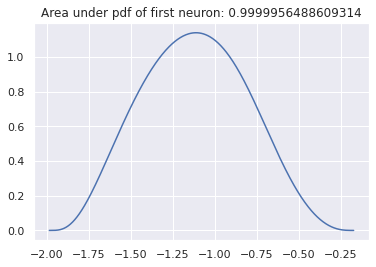

In [17]:
q_pdf, w = vimlts_ff.get_w_dist()
plt.plot(w[:,0,0], q_pdf[:,0,0])
plt.title(f"Area under pdf of first neuron: {np.trapz(q_pdf[:,0,0], w[:,0,0])}")

In [7]:
from tensorflow.keras.layers import Layer

class Test(Layer):
    def build(self, input_shape):
        self.kernel_b = self.add_weight(name='kernel_b',
                                          shape=(input_shape[1], 10),
                                          initializer=initializers.RandomNormal(mean=-0.5 if True else 0.,stddev=0.2),
                                          trainable=True)
test = Test()
test.build(input_shape=(None,2))
test.weights

[<tf.Variable 'kernel_b:0' shape=(2, 10) dtype=float32, numpy=
 array([[-0.509319  , -0.460681  , -0.639887  , -0.82438666, -0.4892532 ,
         -0.33645502, -0.45039487, -0.8246372 , -0.6788101 , -0.71251917],
        [-0.73419154, -0.53899384, -0.33681184, -0.6785925 , -0.5036967 ,
         -0.68511355, -0.4893994 , -0.5542848 , -0.37214714, -0.5021543 ]],
       dtype=float32)>]

In [12]:
init = [initializers.RandomNormal(mean=-0.5 if True else 0.,stddev=0.2), initializers.Constant(2.)]
shape = (3,4)
tf.stack([i(shape=shape) for i in init], axis=2)

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[-0.5688395 ,  2.        ],
        [-0.4232495 ,  2.        ],
        [-0.51800925,  2.        ],
        [-0.44812754,  2.        ]],

       [[-0.38225392,  2.        ],
        [-0.7201966 ,  2.        ],
        [-0.3269279 ,  2.        ],
        [-0.9576684 ,  2.        ]],

       [[-0.61414176,  2.        ],
        [-0.10395563,  2.        ],
        [-0.864938  ,  2.        ],
        [-0.703622  ,  2.        ]]], dtype=float32)>